In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import statsmodels.formula.api as sm
import statsmodels.stats.multitest as smm
# import plotly.express as px
import scipy.stats as scs
import seaborn as sns
import math
import matplotlib.colors as colors
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
data_hpa = pd.read_csv('<Path to the effect sizes on cognitive ability when deleted and duplicated for the genesets of interests>', sep='\t')
data_hpa_clean = data_hpa[(data_hpa.cat == 'g') &
                        (data_hpa.ancestry == 'All') &
                        (data_hpa.diagnosis == 'wo_ASD') &
                          (data_hpa.model_type == '3_3') 
                           ]
print(data_hpa_clean.shape)
data_all =  data_hpa_clean

(1290, 22)


In [3]:
# Prepare the data for the tagDS computation on our genesets of interest
ratio = 0.426609501927956 # Ratio of differences between average effect of DEL and DUP on cognitive ability
colors_del = plt.cm.Reds(np.linspace(0, 1, 256))
colors_dup = plt.cm.Blues(np.linspace(1, 0, 256))
all_colors = np.vstack((colors_dup, colors_del))
del_dup_spe = colors.LinearSegmentedColormap.from_list('del_dup_spe', all_colors)

def compute_tagDS(es_data, data_CNV, a=1, b=-1, c=0):
    tagDS_vals = []
    for i, row in es_data.iterrows():
        distance = abs(a*row.Estimate_DEL + b*row.Estimate_DUP + c)/math.sqrt((a**2)+(b**2))
        delta_y = a*row.Estimate_DEL - row.Estimate_DUP
        if (delta_y > 0) & (a > 0):
            distance = -distance
        tagDS_vals.append(distance)
    es_data['tagDS'] = tagDS_vals 
    random_distri_tagDS = pd.read_csv('<Path to list of normalized tagDS for each geneset sizes>', sep='\t')
    tmp_data = pd.merge(es_data, data_CNV[data_CNV.TYPE=='DEL'].loc[:,['gene_list_name', 'gene_list_n']], on='gene_list_name', how='inner')

    tmp = pd.merge(tmp_data, random_distri_tagDS[['size', 'mu_s', 'sd_s']], left_on='gene_list_n', right_on='size', how='inner')
    tmp['zTagDS'] = (tmp['tagDS'] - tmp['mu_s'])/tmp['sd_s']
    return tmp

In [5]:
# Compute the adjusted p-values (FDR correction) for each gene list

new_data = pd.DataFrame()
for cnv_type in data_all.TYPE.unique():
    for combo in set(zip(data_all['model_type'], data_all['win'],  data_all['diagnosis'])):
        tmp = data_all[(data_all.TYPE==cnv_type) & (data_all.model_type==combo[0]) & (data_all.win==combo[1]) & (data_all.diagnosis==combo[2])].copy()
        tmp['pvalue_adj'] = smm.fdrcorrection(tmp['pvalue'])[1]
        new_data = pd.concat([new_data, tmp])
        
print(new_data.gene_list_name.nunique())

5446


/home/rennetho/python_env/ENV/lib/python3.10/site-packages/seaborn/utils.py:122: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scout = method(scout_x, scout_y, **kws)
/home/rennetho/python_env/ENV/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/rennetho/python_env/ENV/lib/python3.10/site-packages/seaborn/utils.py:122: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  scout = method(scout_x, scout_y, **kws)
/home/rennetho/python_env/ENV/lib/python3.10/site-packages/seaborn/relational.py:573: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  points = ax.scatter(x=x, y=y, **kws)
/home/rennetho/python_env/ENV/lib/python3.10/site-packages/seaborn/utils.py:122: UserWarning: No data for colorm

For windows 1 Spearman = -0.75(p=8.1e-70)
For windows 2 Spearman = -0.66(p=1.2e-66)
For windows 3 Spearman = -0.43(p=9.5e-08)
(-0.7746618076844154, 1.0289947180694146)
(-0.6543355118854935, 0.2965057908821301)


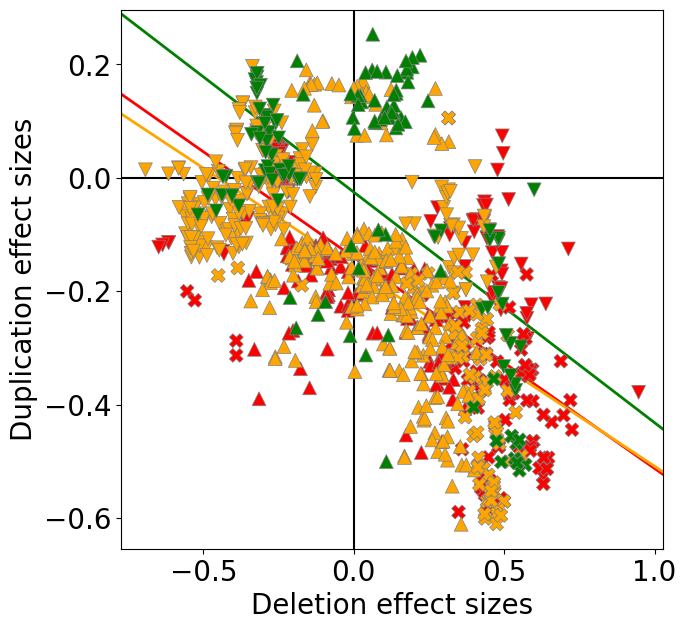

In [6]:
def plot_concordance_LOEUF(new_data, use_or=True, min_pval_del=1, min_pval_DUP=1, win =1 ):
    new_data_control = new_data[new_data.win==win]
    dels = new_data_control[(new_data_control.TYPE == 'DEL')][['gene_list_name','pvalue_adj', 'Estimate']]
    dels.columns =['gene_list_name', 'pvalue_DEL', 'Estimate_DEL']
    dups = new_data_control[new_data_control.TYPE == 'DUP'][['gene_list_name','pvalue_adj', 'Estimate']]
    dups.columns =['gene_list_name', 'pvalue_DUP', 'Estimate_DUP']
    efs = pd.merge(dels, dups, on='gene_list_name')

    if use_or:
        efs_filter= efs[(efs.pvalue_DEL < min_pval_del) | (efs.pvalue_DUP < min_pval_DUP)].copy()
    else:
        efs_filter= efs[(efs.pvalue_DEL < min_pval_del) & (efs.pvalue_DUP < min_pval_DUP)].copy()
        
    formula = 'Estimate_DUP ~ Estimate_DEL'
    reg = sm.gls(formula, data=efs_filter).fit()
    b, a = reg.params

    pearson = scs.pearsonr(efs_filter.Estimate_DUP, efs_filter.Estimate_DEL)
    
    spear = scs.spearmanr(efs_filter.Estimate_DEL, efs_filter.Estimate_DUP)

    plt.axline(xy1=(0, b), slope=a, alpha=1, color=colors_loeuf[win-1], lw=2)

    divnormtag = colors.TwoSlopeNorm(vmin=-2, vcenter=0, vmax=2)
    efs_filter['shape'] = np.where(efs_filter.pvalue_DEL < 0.05, np.where(efs_filter.pvalue_DUP < 0.05, 'Both significant', "DEL significant") ,'DUP significant')

    markers = {'Both significant':'X', "DEL significant":'v' ,'DUP significant':'^'}
    scatter = sns.scatterplot(data=efs_filter, x='Estimate_DEL', y='Estimate_DUP', c=colors_loeuf[win-1], s=100, style='shape', markers=markers, zorder=3,  norm=divnormtag, cmap=del_dup_spe, edgecolor='grey', linewidth=.5)
    print('For windows {} Spearman = {:.2f}(p={:.1e})'.format(win, spear[0], spear[1]))



plt.rc('font', size=20)
fig, ax = plt.subplots(figsize=(7,7))

plt.axhline(y=0, color = 'black')
plt.axvline(x=0, color = 'black')
colors_loeuf = ['red', 'orange', 'green']
plot_concordance_LOEUF(new_data, use_or=True, min_pval_del=0.05, min_pval_DUP=0.05, win=1)    
plot_concordance_LOEUF(new_data, use_or=True, min_pval_del=0.05, min_pval_DUP=0.05, win=2)    
plot_concordance_LOEUF(new_data, use_or=True, min_pval_del=0.05, min_pval_DUP=0.05, win=3)    
plt.xlabel('Deletion effect sizes')
plt.ylabel('Duplication effect sizes')
print(ax.get_xlim())
print(ax.get_ylim())
ax.get_legend().remove()

plt.show()